![](https://api.brandy.run/core/core-logo-wide)

# Supervised Learning: Emojis Multiclass

Vamos ver un ejemplo más complejo con un modelo del tipo multioutput, en que la respuesta de una predicción no es un único valor, sino que un vector. Te auxiliaremos con parte del processo. Todas las celdas que requieren que escribas algo de código están propriamente identificadas.

In [1]:
from PIL import Image
import numpy as np
from os import listdir
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Definimos una variable `size` que en lugar de escribirla en cada instancia en que sea necesaria. 
# Eso nos permite con mayor facilidad entrenar nuestro modelo con imagenes mayores o menores.
# Puedes eligir y probar otros valores para ese parámetro. Las imagenes originales posén (72,72).
# Acuerdate que más pixeles son más features y en ese caso más modelos, con lo cual subir mucho ese 
# valor puede resultar en modemos que tarden mucho en el entrenamiento.

size = (24,24)
pixels = size[0]*size[1]

In [4]:
X, y = [], []
for folder in ["Google","Facebook","Apple","Samsung","Windows"]:
    files = listdir(f"./emojis/{folder}")
    for file in files:
        if file == ".DS_Store":
            continue
        path = f"./emojis/{folder}/{file}"
        
        # Abrimos cada imagen, escalando su tamaño al `size` eligido y convertiendo a RGB.
        # La conversión a RGB remueve la transparéncia
        color = Image.open(path).resize(size).convert("RGB")
        
        # También hacemos una copia en escale de gris del imagen.
        b_n_w = color.convert("L")
        
        # Por último añadimos las imagenes a nuestras variables X y y.
        y.append(np.array(color))
        X.append(np.array(b_n_w))
X,y = np.array(X),np.array(y)

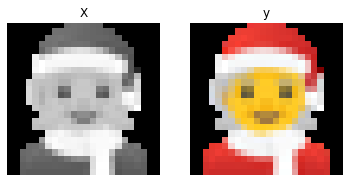

In [5]:
emoji_number = 0

plt.subplot(1,2,1)
plt.imshow(X[emoji_number],cmap="gray")
plt.title("X")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(y[emoji_number])
plt.title("y")
plt.axis("off")

plt.show()

## Step 1. Preparing Data

Como puedes ver por nuestra definición de X e y, intentaremos entrenar un modelo que sea capaz de colorear un emoji en blanco y negro.

In [6]:
X.shape

(2096, 24, 24)

In [7]:
y.shape

(2096, 24, 24, 3)

Según los shapes de nuestros datos, la X (imagenes en blanco y negro) tiene 3 dimensiones y la y (imagenes en color) tiene 4 (la última siendo los 3 canales RGB). Es necesário que sean matrices bi-dimensionales. Ejecuta un `.reshape` con X para que pase a ser una matriz con `2096` imagenes (filas) con el valor de cada pixel como suas features (columnas)

In [8]:
### ~~~ Esa celda requiere tu atención ~~~
X = X.reshape

Hazlo apenas para la X, en el caso de las imagenes en color, tendremos que separar los 3 canales y lo haremos despues del `train_test_split`.

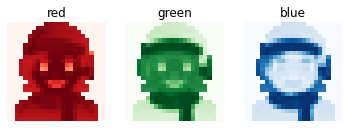

In [9]:
for channel, color in enumerate(["red","green","blue"]):
    plt.subplot(1,3,channel+1)
    single_channel_image = y[0,:,:,channel]
    plt.imshow(single_channel_image, cmap=color.title()+"s")
    plt.title(color)
    plt.axis("off")

In [10]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

TypeError: Singleton array array(<built-in method reshape of numpy.ndarray object at 0x7fe3a3f90bd0>,
      dtype=object) cannot be considered a valid collection.

Ahora que tenemos los datos divididos en Train y Test, debemos separar los canales de cada imagen (como hizo el el plot arriba para ilustrar la decomposición). Escribe el código necesário para que las variables `y_train` e `y_test` tengan el formato ilustrado abajo, donde cada lista vacia es un numpy array con la misma cantidad de imagenes (1572 en train, 524 en test) y los pixeles como columnas. Pero que cada value del diccionario tenga apenas los valores del canal correspondiente.

```python
y_train = {
    "red": [],
    "blue": [],
    "green": []
}

y_test = {
    "red": [],
    "blue": [],
    "green": []
}
```


## Step 2. Training Model

Tenemos un problema del tipo multioutput, pero el modelo que vamos utilizar es la Regresión Lineal, que no es directamente competible con ese tipo de problema. Para eso usaremos el `MultiOutputRegressor`. 

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
# Utilizaremos 3 modelos, uno para cada canal.
# El parámetro `n_jobs` indica cuantos nucleos de cpu se deben utilizar para entrenar y predecir. 
# Si le definimos como -1 se usaran todos que estén disponíbles

model = {channel:MultiOutputRegressor(LinearRegression(), n_jobs=-1) for channel in ["red","green","blue"]}

Escribe un bucle para entrenar cada modelo con los datos apropriados!

Todos utilizaran la misma X, pero cada uno tendrá su `y` especifica, guardada en el dicionário que definimos previamente.

In [ ]:
### ~~~ Esa celda requiere tu atención ~~~

# Train model here

## Step 3. Predicting

A partir de aqui puedes simplemente ejecutar las celdas y disfrutar. Investiga el codigo y como funciona cada celda! Toca y prueba. 

Como tenemos 3 modelos entrenados separadamente para los 3 canales, también tendremos que hacer 3 prediciones y recomponerles en una única imagen.

In [ ]:
im_pred = {
    channel : model[channel].predict(X_test).reshape(X_test.shape[0],*size) for channel in ["red","green","blue"]
}

In [ ]:
def compose_picture(r,g,b):
    image = np.stack([r,g,b], axis = -1) 
    # We change negative pixel values into 0. Negatives come from the prediction
    image = np.where(image < 0, 0, image)
    # We make it so individual pixel values are between 0 and 1
    image = image/image.max()
    return image

## Printing One Example

In [ ]:
image_number = 0

plt.figure(figsize=(8,6))
plt.subplot(1,6,1)
plt.imshow(X_test[image_number].reshape(*size), cmap="gray")
plt.title("X_test")
plt.axis("off")

for i, channel in enumerate(["red","green","blue"]):
    plt.subplot(1,6,i+2)
    plt.imshow(im_pred[channel][image_number].reshape(*size), cmap=channel.title()+"s")
    plt.title(f"pred_{channel}")
    plt.axis("off")
    
plt.subplot(1,6,5)
composed_image = compose_picture(*[im_pred[channel][image_number].reshape(*size) for channel in ["red","green","blue"]])
plt.imshow(composed_image)
plt.title("pred_comp")
plt.axis("off")

plt.subplot(1,6,6)
original_image = compose_picture(*[y_test[channel][image_number].reshape(*size) for channel in ["red","green","blue"]])
plt.imshow(original_image)
plt.title("original")
plt.axis("off")

plt.show()

## Printing some more examples

In [ ]:
images_X = X_test.reshape(X_test.shape[0],*size)
images_y = [compose_picture(*[y_test[channel][i].reshape(*size) for channel in ["red","green","blue"]]) for i in range(y_test["red"].shape[0])]
images_pred = [compose_picture(*[im_pred[channel][i].reshape(*size) for channel in ["red","green","blue"]]) for i in range(im_pred["red"].shape[0])]

In [ ]:
n_images = 10

plt.figure(figsize=(4,5*n_images))
images = [im for tup in (zip(images_X,images_y,images_pred)) for im in tup]
titles = ["Gray", "Original", "Predicted"]*n_images
for i in range(n_images*3):
    plt.subplot(n_images*3,3,i+1)
    if titles[i] == "Gray":
        plt.imshow(images[i], cmap="gray")
    else:
        plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis("off")

## Step 4. Predicting with images from a different source

Ahora es donde verdaderamente testeamos nuestro modelo! Vamos cargar imagenes que el nunca vió y además no tienen el mismo origen que el dataset de train y test.

In [ ]:
def predict_images(models, X):
    im_pred = {
    channel : models[channel].predict(X).reshape(X.shape[0],*size) for channel in ["red","green","blue"]
}
    return np.array([compose_picture(*[im_pred[channel][i].reshape(*size) for channel in ["red","green","blue"]]) for i in range(im_pred["red"].shape[0])])

In [ ]:
path = "./test_images"
images = np.array([np.array(Image.open(f"{path}/{image}.png").resize(size).convert("L")) for image in range(1,5)])

In [ ]:
for i in range(len(images)):
    plt.subplot(1,len(images),i+1)
    plt.imshow(images[i], cmap="gray")
    plt.axis("off")

In [ ]:
predicted = predict_images(model, images.reshape(len(images),pixels))

In [ ]:
for i in range(len(predicted)):
    plt.subplot(1,len(predicted),i+1)
    plt.imshow(predicted[i], cmap="gray")
    plt.axis("off")

## Keep on Coding!

Espero que hayas disfrutado de esa experiencia por el Machine Learning y que veas que simples regresiones lineales pueden abrir las puertas para cosas bastante guays si utilizamos bien las herramientas.

Limitamos el dataset en ese ejemplo a emojis que contengan algun tipo de cara, sea de personaje humano o animal. Si quieres, puedes probarlo con todos los emojis. Los datos pueden ser encontrados [aqui.](https://www.kaggle.com/subinium/emojiimage-dataset)